# Extract Liberty Mutual auto table 

Author: Mo Al Elew

**What notebook does/produces:**

Extracts territory rate setting tables from Auto Club filing PDFs and produces data files for analysis

**Issue/problem being solved:**

- Table is stored in a PDF

**Strategy to solve:**

General pattern:

1. Extract table data from PDF
2. Clean and process the data into a standardized format
3. Run any necessary caclulations to produce location effect figure
4. Match on geographic and demographic data
5. Determine nearest neighbor with lowest base rate

**Sources:**

- data.census.gov
- https://www2.census.gov/geo/tiger/TIGER2020/
- System for Electronic Rates and Forms Filing (SERFF)


In [1]:
import geopandas as gpd
import pandas as pd
import stringcase
import tabula

# Constants

In [2]:
# file paths
RATE_TABLE_PDF_FP = (
    "./inputs/mi-leg-ao-manual-liberty-mutual-auto-territory-rate-table.pdf"
)
COUNTY_GIS_FILE = "../01_demographics/outputs/county_demographics_map.geojson"

PROCESSED_EXPORT_FP = "./outputs/libertymutual_auto.csv"
GIS_EXPORT_FP = "./outputs/libertymutual_auto_gis.geojson"
RAW_EXPORT_FP = "./outputs/rate_table.csv"
CLEAN_EXPORT_FP = "./outputs/libertymutual_auto_clean.csv"
CLEAN_MAP_EXPORT_FP = "./outputs/libertymutual_auto_clean.geojson"

In [3]:
# constant values
COMPANY_NAME = "Liberty Mutual"
VEHICLE_TYPE = "Auto"
FACTOR_CIRCUMVENTED = "zip"
FACTOR_NAME = "Garaging Territory"
GEOGRAPHY_FACTOR = "Territory"
GEOGRAPHY_TYPE = "county"

RATE_PREFIX = "rate_"

PROJECTED_CRS = "EPSG:3078"

In [4]:
# column sets
BASE_COLUMNS = [
    "company",
    "vehicle_type",
    "factor_circumvented",
    "factor_name",
    "geography_factor",
    "geography_type",
    "geography_factor_id",
    "latitude",
    "longitude",
    "county_fips",
    "county_name",
    "tract_fips",
    "block_group_fips",
    "zip",
    "place_name_fips",
]

CLEAN_EXPORT_COLS = [
    "geo_id",
    "geo_name",
    "total_pop",
    "white_pct",
    "black_pct",
    "white_tot",
    "black_tot",
    "median_income",
    "density",
    "generic_location_based_premium",
    "location_effect",
]

In [5]:
def get_rate_columns(df_rate_table):
    return [col for col in df_rate_table.columns if col.startswith(RATE_PREFIX)]


def get_avg_rate_factor(df_rate_table):
    rate_cols = get_rate_columns(df_rate_table)
    return df_rate_table[rate_cols].mean(axis=1)

# Read table

## Territory rate table

In [6]:
col2str = {"dtype": str}
kwargs = {"pandas_options": col2str}
TERRITORY_TABLES_LIST = tabula.read_pdf(
    RATE_TABLE_PDF_FP, pages="all", lattice=True, **kwargs
)
DF_TERRITORY_RATES = pd.concat(TERRITORY_TABLES_LIST)
DF_TERRITORY_RATES.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83 entries, 0 to 40
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Territory  83 non-null     object
 1   Liability  83 non-null     object
 2   PIP        83 non-null     object
 3   PPI        83 non-null     object
 4   Comp       83 non-null     object
 5   Collision  83 non-null     object
dtypes: object(6)
memory usage: 4.5+ KB


## County demographics

In [7]:
gdf_county = gpd.read_file(COUNTY_GIS_FILE)

# Build processed table

In [8]:
df_processed_table = DF_TERRITORY_RATES.copy()

## Rename columns

In [9]:
def create_rate_label(col_name):
    RATE_PREFIX = "rate_"
    return RATE_PREFIX + stringcase.snakecase(col_name.lower()).replace("___", "_")


def rename_rate_columns(df):
    rate_col_names = df.columns[1:]
    extracted_rate_col_names = [
        create_rate_label(col_name) for col_name in rate_col_names
    ]
    rate_col_renames = dict(zip(rate_col_names, extracted_rate_col_names))
    return df.rename(columns=rate_col_renames)


df_processed_table = rename_rate_columns(df_processed_table)
rate_col_names = list(df_processed_table.columns[1:])
df_processed_table

,Territory,rate_liability,rate_pip,rate_ppi,rate_comp,rate_collision
0,001,3759,9352,351,8585,19964
1,002,3567,8126,355,7562,21692
2,003,3481,9384,336,5221,24261
3,004,3540,8371,334,8004,19493
4,005,3721,8308,324,5767,25315
...,...,...,...,...,...,...
36,079,4321,12396,361,8091,23518
37,080,3886,9203,366,5631,23715
38,081,3443,8571,320,4994,23732
39,082,5211,16046,447,10236,31326


## Calculate location base rate

In [10]:
df_processed_table[get_rate_columns(df_processed_table)] = df_processed_table[
    get_rate_columns(df_processed_table)
].astype(int)
df_processed_table["generic_location_based_premium"] = df_processed_table[
    get_rate_columns(df_processed_table)
].sum(axis=1)
df_processed_table

,Territory,rate_liability,rate_pip,rate_ppi,rate_comp,rate_collision,generic_location_based_premium
0,001,3759,9352,351,8585,19964,42011
1,002,3567,8126,355,7562,21692,41302
2,003,3481,9384,336,5221,24261,42683
3,004,3540,8371,334,8004,19493,39742
4,005,3721,8308,324,5767,25315,43435
...,...,...,...,...,...,...,...
36,079,4321,12396,361,8091,23518,48687
37,080,3886,9203,366,5631,23715,42801
38,081,3443,8571,320,4994,23732,41060
39,082,5211,16046,447,10236,31326,63266


## Index to median

In [11]:
median_loc_base_rate = df_processed_table["generic_location_based_premium"].median()
df_processed_table["location_effect"] = round(
    df_processed_table["generic_location_based_premium"] / median_loc_base_rate, 2
)

## Geography columns

Rename geography index column 

In [12]:
rate_col_names = rate_col_names + [
    "generic_location_based_premium",
    "location_effect",
]

In [13]:
df_processed_table = df_processed_table.rename(
    columns={"Territory": "geography_factor_id"}
)
df_processed_table

,geography_factor_id,rate_liability,rate_pip,rate_ppi,rate_comp,rate_collision,generic_location_based_premium,location_effect
0,001,3759,9352,351,8585,19964,42011,0.97
1,002,3567,8126,355,7562,21692,41302,0.95
2,003,3481,9384,336,5221,24261,42683,0.99
3,004,3540,8371,334,8004,19493,39742,0.92
4,005,3721,8308,324,5767,25315,43435,1.00
...,...,...,...,...,...,...,...,...
36,079,4321,12396,361,8091,23518,48687,1.12
37,080,3886,9203,366,5631,23715,42801,0.99
38,081,3443,8571,320,4994,23732,41060,0.95
39,082,5211,16046,447,10236,31326,63266,1.46


## Fill constants

In [14]:
df_processed_table["company"] = COMPANY_NAME
df_processed_table["vehicle_type"] = VEHICLE_TYPE
df_processed_table["factor_circumvented"] = FACTOR_CIRCUMVENTED
df_processed_table["factor_name"] = FACTOR_NAME
df_processed_table["geography_factor"] = GEOGRAPHY_FACTOR
df_processed_table["geography_type"] = GEOGRAPHY_TYPE

In [15]:
def fill_null_columns(df, base_columns):
    base_col_to_fill = list(set(base_columns) - set(df.columns))
    df[base_col_to_fill] = None
    return df


df_processed_table = fill_null_columns(df_processed_table, BASE_COLUMNS)
df_processed_table

,geography_factor_id,rate_liability,rate_pip,rate_ppi,rate_comp,rate_collision,generic_location_based_premium,location_effect,company,vehicle_type,...,geography_factor,geography_type,county_name,tract_fips,county_fips,zip,block_group_fips,latitude,place_name_fips,longitude
0,001,3759,9352,351,8585,19964,42011,0.97,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
1,002,3567,8126,355,7562,21692,41302,0.95,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
2,003,3481,9384,336,5221,24261,42683,0.99,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
3,004,3540,8371,334,8004,19493,39742,0.92,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
4,005,3721,8308,324,5767,25315,43435,1.00,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36,079,4321,12396,361,8091,23518,48687,1.12,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
37,080,3886,9203,366,5631,23715,42801,0.99,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
38,081,3443,8571,320,4994,23732,41060,0.95,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None
39,082,5211,16046,447,10236,31326,63266,1.46,Liberty Mutual,Auto,...,Territory,county,None,None,None,None,None,None,None,None


# Join geographic and demographic data with insurance tables

Create matching alpha indexed county identifiers

In [16]:
# 1-indexed
gdf_county = gdf_county.sort_values("name")
alpha_indexed_num = [str(i + 1) for i in range(len(gdf_county))]
alpha_indexed_num = [i.zfill(3) for i in alpha_indexed_num]
gdf_county["county_alpha_index"] = alpha_indexed_num
gdf_county

,statefp,countyfp,countyns,geoid,geoidfq,name,namelsad,lsad,classfp,mtfcc,...,white_tot,black_tot,aian_tot,asian_tot,nhpi_tot,other_tot,two_plus_tot,median_income,geometry,county_alpha_index
17,26,001,01622943,26001,0500000US26001,Alcona,Alcona County,06,H1,G4020,...,9603,44,31,32,2,26,311,50295,"POLYGON ((-83.40147 44.51170, -83.40255 44.511...",001
6,26,003,01622944,26003,0500000US26003,Alger,Alger County,06,H1,G4020,...,7266,691,283,70,0,6,375,55528,"POLYGON ((-86.67818 46.15856, -86.67821 46.158...",002
75,26,005,01622945,26005,0500000US26005,Allegan,Allegan County,06,H1,G4020,...,103592,1520,287,872,21,463,4133,75543,"POLYGON ((-86.01162 42.41891, -86.01293 42.418...",003
1,26,007,01622946,26007,0500000US26007,Alpena,Alpena County,06,H1,G4020,...,27248,222,30,134,0,97,738,49133,"POLYGON ((-83.37465 45.20709, -83.36981 45.207...",004
21,26,009,01622947,26009,0500000US26009,Antrim,Antrim County,06,H1,G4020,...,22075,148,107,85,0,106,558,68850,"POLYGON ((-85.09135 44.85869, -85.09571 44.858...",005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37,26,157,01623019,26157,0500000US26157,Tuscola,Tuscola County,06,H1,G4020,...,48939,558,143,258,0,78,1222,59815,"POLYGON ((-83.46071 43.23279, -83.46074 43.225...",079
10,26,159,01623020,26159,0500000US26159,Van Buren,Van Buren County,06,H1,G4020,...,60368,2548,213,472,0,128,2933,65531,"POLYGON ((-85.76551 42.33171, -85.76553 42.330...",080
39,26,161,01623021,26161,0500000US26161,Washtenaw,Washtenaw County,06,H1,G4020,...,254046,42224,664,33872,121,1609,18787,84245,"POLYGON ((-83.54373 42.26246, -83.54377 42.261...",081
9,26,163,01623022,26163,0500000US26163,Wayne,Wayne County,06,H1,G4020,...,866868,666184,3226,61215,314,7876,63259,57223,"POLYGON ((-82.89881 42.35794, -82.90614 42.356...",082


<Axes: >

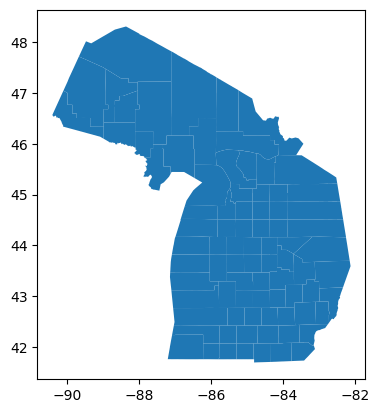

In [17]:
assert set(gdf_county["county_alpha_index"]) == set(
    df_processed_table["geography_factor_id"]
)
gdf_rates_demographics_merged = gdf_county.merge(
    df_processed_table,
    left_on="county_alpha_index",
    right_on="geography_factor_id",
    validate="1:1",
)
gdf_rates_demographics_merged.plot()

Set county fips columns

In [18]:
gdf_rates_demographics_merged["county_fips"] = gdf_rates_demographics_merged["geo_id"]

## Population density

In [19]:
gdf_rates_demographics_merged["density"] = (
    gdf_rates_demographics_merged["total_pop"]
    / gdf_rates_demographics_merged.to_crs(PROJECTED_CRS).area
)

# Export

In [20]:
gdf_rates_demographics_merged.to_file(GIS_EXPORT_FP, driver="GeoJSON")

In [21]:
expected_col_order = BASE_COLUMNS + rate_col_names
gdf_rates_demographics_merged["county_name"] = gdf_rates_demographics_merged["geo_name"]
df_export = gdf_rates_demographics_merged[expected_col_order]
df_export.to_csv(PROCESSED_EXPORT_FP, index=False)
df_export.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83 entries, 0 to 82
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   company                         83 non-null     object 
 1   vehicle_type                    83 non-null     object 
 2   factor_circumvented             83 non-null     object 
 3   factor_name                     83 non-null     object 
 4   geography_factor                83 non-null     object 
 5   geography_type                  83 non-null     object 
 6   geography_factor_id             83 non-null     object 
 7   latitude                        0 non-null      object 
 8   longitude                       0 non-null      object 
 9   county_fips                     83 non-null     object 
 10  county_name                     83 non-null     object 
 11  tract_fips                      0 non-null      object 
 12  block_group_fips                0 non-

In [22]:
DF_TERRITORY_RATES.to_csv(RAW_EXPORT_FP, index=False)

In [23]:
gdf_rates_demographics_merged[CLEAN_EXPORT_COLS].to_csv(CLEAN_EXPORT_FP, index=False)
gdf_rates_demographics_merged[CLEAN_EXPORT_COLS + ["geometry"]].to_file(
    CLEAN_MAP_EXPORT_FP, driver="GeoJSON"
)

# Appendix